In [46]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from fastrbm.dataset import load_dataset
from fastrbm.methods.ll_binary import compute_log_likelihood_AIS_PT
from fastrbm.plot import plot_PCA, plot_image
from fastrbm.utils import get_eigenvalues_history, get_all_epochs

In [21]:
# use LaTeX fonts in the plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# PyTorch
device = "cuda"

In [51]:
dataset_name = "MICKEY"
train_dataset, test_dataset = load_dataset("MICKEY", variable_type="Bernoulli", use_torch=True)

num_visibles = train_dataset.get_num_visibles()

cov_data = train_dataset.get_covariance_matrix(device=device).float()
U_data, S_data, V_dataT = torch.linalg.svd(cov_data)
data_proj = train_dataset.data @ V_dataT.mT / num_visibles**.5
data_proj = data_proj.cpu().numpy()

In [52]:
model_name = "../RBM.h5"
filename_log = "../log-RBM.csv"

with h5py.File(model_name, "r") as f:
    min_eps = f["hyperparameters"]["min_eps"][()]
    parallel_chains = f["parallel_chains"][()]
epochs = get_all_epochs(model_name)

The next plot is relevant for the Jar-RBM but not for the PCD RBM.

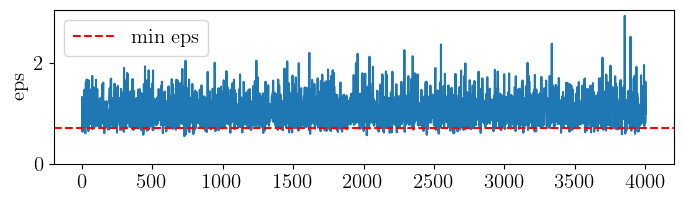

In [53]:
log_df = pd.read_csv(filename_log)
gradient_update = np.arange(len(log_df)) + 1
fig, ax = plt.subplots(1, 1, figsize=(8,2))
ax.plot(gradient_update, log_df["eps"])
ax.set_ylabel(r"eps")
ax.set_ylim(0)
ax.axhline(y=min_eps, ls="dashed", color="red", label="min eps")
ax.legend()

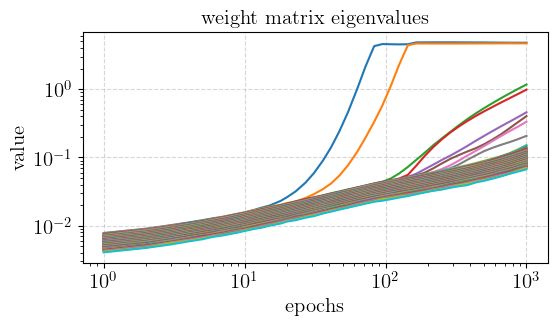

In [54]:
gradient_updates, eigenvalues = get_eigenvalues_history(model_name)

fig, ax = plt.subplots(dpi=100, nrows=1, ncols=1, figsize=(6, 3))
ax.set_title('weight matrix eigenvalues', size=15)
ax.set_xlabel('epochs')
ax.set_ylabel('value')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.5, ls='dashed')
ax.plot(epochs, eigenvalues);

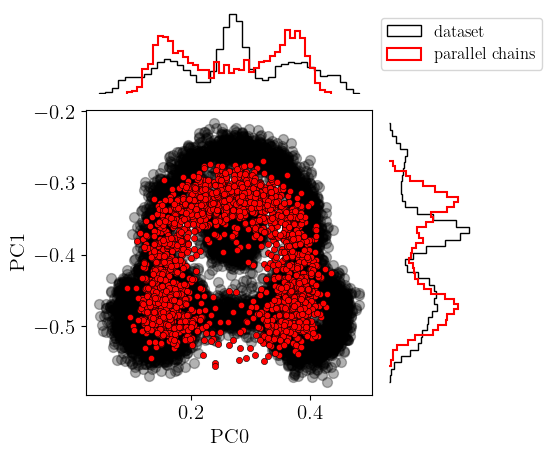

In [55]:
pc_proj = parallel_chains @ V_dataT.mT.cpu().numpy() / num_visibles**.5

plot_PCA(data_proj, pc_proj, labels = ["dataset", "parallel chains"])

# Log-likelihood

For the next part, you will need to have generated samples using the `scripts/ptt_sampling.py` file.

In [57]:
sample_filename = "../sample_RBM_mickey.h5"

with h5py.File(sample_filename, "r") as f:
    sel_epochs = f["sel_epochs"][()]
    chains = torch.from_numpy(f["gen_chains"][()]).to(device)


In [59]:
ll_test = compute_log_likelihood_AIS_PT(model_name, sel_epochs, chains, test_dataset, device=device)

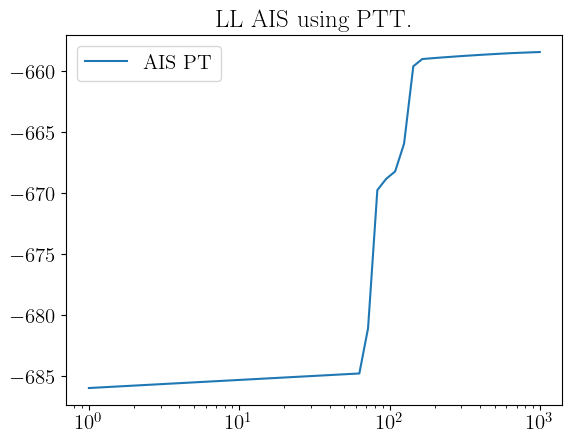

In [64]:
fig, ax =plt.subplots(1, 1)

ax.plot(sel_epochs, ll_test.cpu().numpy(), label="AIS PT")
ax.set_title("LL AIS using PTT.")
ax.semilogx()
ax.legend()

# Generated data

In [66]:
ep = -1

samples_gen = chains[ep]
gen_proj = samples_gen@ V_dataT.mT / num_visibles**.5
gen_proj = gen_proj.cpu().numpy()

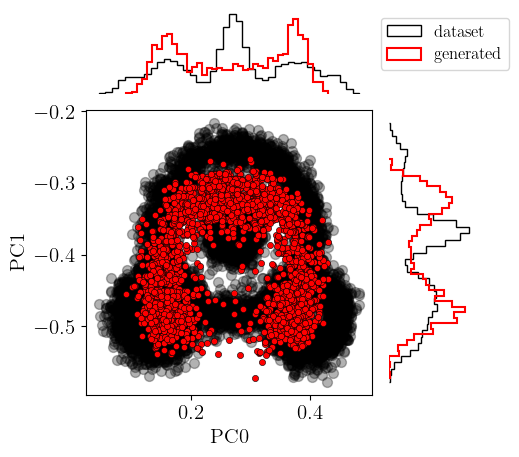

In [68]:
plot_PCA(data_proj, gen_proj, labels=["dataset", "generated"])